<h1 align="center">TensorFlow Neural Network Lab</h1>

<img src="image/notmnist.png">
In this lab, you'll use all the tools you learned from *Introduction to TensorFlow* to label images of English letters! The data you are using, <a href="http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html">notMNIST</a>, consists of images of a letter from A to J in different fonts.

The above images are a few examples of the data you'll be training on. After training the network, you will compare your prediction model against test data. Your goal, by the end of this lab, is to make predictions against that test set with at least an 80% accuracy. Let's jump in!

To start this lab, you first need to import all the necessary modules. Run the code below. If it runs successfully, it will print "`All modules imported`".

In [1]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

print('All modules imported.')

All modules imported.


The notMNIST dataset is too large for many computers to handle.  It contains 500,000 images for just training.  You'll be using a subset of this data, 15,000 images for each label (A-J).

In [2]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Make sure the files aren't corrupted
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

All files downloaded.


In [3]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')#tqdm displays progress bar. 
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            #print (filename)
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    #print (image_file)
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')


100%|███████████████████████████████████████████████████████████████████████| 10001/10001 [00:02<00:00, 4641.62files/s]


In [4]:
# Limit the amount of data to work with a docker container
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Set flags for feature engineering.This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

All features and labels uncompressed.


<img src="image/Mean Variance - Image.png" style="height: 75%;width: 75%; position: relative; right: 5%">
## Problem 1
The first problem involves normalizing the features for your training and test data.

Implement Min-Max scaling in the `normalize_grayscale()` function to a range of `a=0.1` and `b=0.9`. After scaling, the values of the pixels in the input data should range from 0.1 to 0.9.

Since the raw notMNIST image data is in [grayscale](https://en.wikipedia.org/wiki/Grayscale), the current values range from a min of 0 to a max of 255.

Min-Max Scaling:
$
X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
$

*If you're having trouble solving problem 1, you can view the solution [here](https://github.com/udacity/deep-learning/blob/master/intro-to-tensorFlow/intro_to_tensorflow_solution.ipynb).*

In [5]:
# Problem 1 - Implement Min-Max scaling for grayscale image data
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image dat
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

### DON'T MODIFY ANYTHING BELOW ###
# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])

if not is_features_normal: #feature has not been normalized yet. 
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True

print('Tests Passed!')

Tests Passed!


In [6]:
train_labels

array(['J', 'H', 'D', ..., 'C', 'C', 'I'], dtype='<U1')

In [7]:
len(train_labels)

150000

In [8]:
train_features[0]

array([0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.11568628, 0.23490196, 0.35411766, 0.46078432,
       0.5862745 , 0.70549023, 0.7619608 , 0.8152942 , 0.8905883 ,
       0.8717647 , 0.90000004, 0.38235295, 0.1       , 0.11254902,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.14078432, 0.49215686,
       0.8027451 , 0.7839216 , 0.72431374, 0.66470593, 0.542353  ,
       0.68980396, 0.90000004, 0.8905883 , 0.874902  , 0.90000004,
       0.3854902 , 0.1       , 0.11254902, 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.14705883, 0.24745098, 0.14078432, 0.1       ,
       0.10313725, 0.11568628, 0.1       , 0.4482353 , 0.90000004,
       0.8780393 , 0.874902  , 0.90000004, 0.3854902 , 0.1    

In [9]:
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer() #more dense than one-hot encoding. 
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [10]:
train_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [11]:
train_labels.shape

(150000, 10)

In [12]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


The pickle module implements binary protocols for serializing and de-serializing a Python object structure. “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream.

In [13]:
# Save the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


# Checkpoint
All your progress is now saved to the pickle file.  If you need to leave and comeback to this lab, you no longer have to start from the beginning.  Just run the code block below and it will load all the data and modules required to proceed.

In [14]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    train_features = pickle_data['train_dataset']
    train_labels = pickle_data['train_labels']
    valid_features = pickle_data['valid_dataset']
    valid_labels = pickle_data['valid_labels']
    test_features = pickle_data['test_dataset']
    test_labels = pickle_data['test_labels']
    del pickle_data  # Free up memory

print('Data and modules loaded.')

Data and modules loaded.


### below problems uses batch gradient descent to update parameters though it is relatively slow as compared to using backward proporgation, which is typical in neural network. 

### Here, there is not even a hidden layer. as we just direcly convert XW to y using softmax.



## Problem 2

Now it's time to build a simple neural network using TensorFlow. Here, your network will be just an input layer and an output layer.

<img src="image/network_diagram.png" style="height: 40%;width: 40%; position: relative; right: 10%">

For the input here the images have been flattened into a vector of $28 \times 28 = 784$ features. Then, we're trying to predict the image digit so there are 10 output units, one for each label. Of course, feel free to add hidden layers if you want, but this notebook is built to guide you through a single layer network. 

For the neural network to train on your data, you need the following <a href="https://www.tensorflow.org/resources/dims_types.html#data-types">float32</a> tensors:
 - `features`
  - Placeholder tensor for feature data (`train_features`/`valid_features`/`test_features`)
 - `labels`
  - Placeholder tensor for label data (`train_labels`/`valid_labels`/`test_labels`)
 - `weights`
  - Variable Tensor with random numbers from a truncated normal distribution.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#truncated_normal">`tf.truncated_normal()` documentation</a> for help.
 - `biases`
  - Variable Tensor with all zeros.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#zeros"> `tf.zeros()` documentation</a> for help.

*If you're having trouble solving problem 2, review "TensorFlow Linear Function" section of the class.  If that doesn't help, the solution for this problem is available [here](intro_to_tensorflow_solution.ipynb).*

In [28]:
# All the pixels in the image (28 * 28 = 784)
features_count = 784
# All the labels
labels_count = 10

# TODO: Set the features and labels tensors
features = tf.placeholder(tf.float32)


labels = tf.placeholder(tf.float32)

# TODO: Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count), mean=0.0, stddev=1.0, dtype=tf.float32, seed=1))
biases = tf.Variable(tf.zeros(labels_count))



### DON'T MODIFY ANYTHING BELOW ###

#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\ #feature shape should be either none or none,784. ow, return incorrect
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, 784]), 'The shape of features is incorrect'
assert labels._shape  == None or (\
    labels._shape.dims[0].value is None and\
    labels._shape.dims[1].value in [None, 10]), 'The shape of labels is incorrect'
assert weights._variable._shape == (784, 10), 'The shape of weights is incorrect'
assert biases._variable._shape == (10), 'The shape of biases is incorrect' #this means 10X1 shape. 

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases #n casesX 784 *784X10=n casesX10

prediction = tf.nn.softmax(logits) #A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1) #sum across features

# Training loss
loss = tf.reduce_mean(cross_entropy) #average across cases. 

# Create an operation that initializes all variables
init = tf.global_variables_initializer()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


$$- \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log \sigma(z^{[2](i)}) + (1-y^{(i)})\log (1-\sigma(z^{[2](i)})\large )\small\tag{2}$$

Below is an explanaton on tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)


In [45]:
y_hat = tf.convert_to_tensor(np.array([[0.5, 1.5, 0.1],[2.2, 1.3, 1.7]]))
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(y_hat)
# array([[ 0.5,  1.5,  0.1],
#        [ 2.2,  1.3,  1.7]])

reduce_sum: Computes the sum of elements across dimensions of a tensor.
reduce_mean: Computes the mean of elements across dimensions of a tensor.

In [53]:
y_hat_softmax = tf.nn.softmax(y_hat)
y_true = tf.convert_to_tensor(np.array([[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]])) 
loss_per_instance_1 = -tf.reduce_sum(y_true * tf.log(y_hat_softmax), reduction_indices=1)
with tf.Session() as sess:
    y_hat_softmax=sess.run(y_hat_softmax)
    y_true=sess.run(y_true)
    loss_per_instance_1=sess.run(loss_per_instance_1)

In [62]:
y_hat_softmax

array([[0.227863  , 0.61939586, 0.15274114],
       [0.49674623, 0.20196195, 0.30129182]])

In [63]:
np.log(y_hat_softmax) #log with base e. 

array([[-1.4790107 , -0.4790107 , -1.8790107 ],
       [-0.69967598, -1.59967598, -1.19967598]])

In [54]:
y_true

array([[0., 1., 0.],
       [0., 0., 1.]])

In [52]:
loss_per_instance_1# loss for each cases

array([0.4790107 , 1.19967598])

below continue with the tutorial

In [64]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1)) #use max because 
#max refers to the one has highest probability or label. 
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32)) #cast it to the new dtype

print('Accuracy function created.')

Accuracy function created.


<img src="image/Learn Rate Tune - Image.png" style="height: 70%;width: 70%">
## Problem 3
Below are 2 parameter configurations for training the neural network. In each configuration, one of the parameters has multiple options. For each configuration, choose the option that gives the best acccuracy.

Parameter configurations:

Configuration 1
* **Epochs:** 1
* **Learning Rate:**
  * 0.8
  * 0.5
  * 0.1
  * 0.05
  * 0.01

Configuration 2
* **Epochs:**
  * 1
  * 2
  * 3
  * 4
  * 5
* **Learning Rate:** 0.2

The code will print out a Loss and Accuracy graph, so you can see how well the neural network performed.

*If you're having trouble solving problem 3, you can view the solution [here](intro_to_tensorflow_solution.ipynb).*

In [94]:
# Change if you have memory restrictions
batch_size = 128

# TODO: Find the best parameters for each configuration
epochs = 1
learning_rate = 0.1



### DON'T MODIFY ANYTHING BELOW ###
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size)) #mini batch gradient descent;
#len(train_features) refers m, number of cases
    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar: #each loop refers to process one batch: 128 cases. 
            # Get a batch of training features and labels
            print (batch_i) 
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]
  
            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})
#model is fit using batch feature and batch label. 

            # Log every 50 batches #this means we caculate accuacry every 50 batches. 
            if not batch_i % log_batch_step:#batch_i=1 means first 128 cases or first batch. 
                #only not 50 % 50 returns true. thus, it records accucary at 
                #50th batch, 100th batch etc. 
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict) #
                #train_feed_dict = {features: train_features, labels: train_labels}
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
                # accurary is calculated using entire training set and valiation set. 

                # Log batches
                previous_batch = batches[-1] if batches else 0 #0 on first run.
                batches.append(log_batch_step + previous_batch) #on first run, returns 50; 
                loss_batch.append(l) #l is the the loss 
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
        test_accuracy1 = session.run(accuracy, feed_dict=test_feed_dict)
        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)


Epoch  1/1:   0%|                                                                        | 0/1114 [00:00<?, ?batches/s]

0



Epoch  1/1:   0%|                                                                | 1/1114 [00:00<08:25,  2.20batches/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21



Epoch  1/1:   2%|█▏                                                             | 22/1114 [00:00<05:49,  3.13batches/s]

22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47



Epoch  1/1:   4%|██▋                                                            | 48/1114 [00:00<03:59,  4.44batches/s]

48
49
50
51
52
53
54
55
56
57
58
59



Epoch  1/1:   5%|███▍                                                           | 60/1114 [00:01<02:58,  5.89batches/s]

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86



Epoch  1/1:   8%|████▉                                                          | 87/1114 [00:01<02:03,  8.33batches/s]

87
88
89
90
91
92
93
94
95
96
97
98
99
100
101



Epoch  1/1:   9%|█████▋                                                        | 102/1114 [00:01<01:35, 10.61batches/s]

102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118



Epoch  1/1:  11%|██████▌                                                       | 119/1114 [00:01<01:07, 14.76batches/s]

119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145



Epoch  1/1:  13%|████████▏                                                     | 146/1114 [00:01<00:47, 20.58batches/s]

146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162



Epoch  1/1:  15%|█████████                                                     | 163/1114 [00:02<00:40, 23.59batches/s]

163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186



Epoch  1/1:  17%|██████████▍                                                   | 187/1114 [00:02<00:28, 32.28batches/s]

187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202



Epoch  1/1:  18%|███████████▎                                                  | 203/1114 [00:03<00:27, 33.05batches/s]

203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228



Epoch  1/1:  21%|████████████▋                                                 | 229/1114 [00:03<00:19, 44.68batches/s]

229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250



Epoch  1/1:  23%|█████████████▉                                                | 251/1114 [00:03<00:19, 44.87batches/s]

251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273



Epoch  1/1:  25%|███████████████▏                                              | 274/1114 [00:03<00:14, 58.98batches/s]

274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300



Epoch  1/1:  27%|████████████████▊                                             | 301/1114 [00:04<00:14, 57.57batches/s]

301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323



Epoch  1/1:  29%|██████████████████                                            | 324/1114 [00:04<00:10, 74.00batches/s]

324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350



Epoch  1/1:  32%|███████████████████▌                                          | 351/1114 [00:04<00:11, 66.88batches/s]

351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374



Epoch  1/1:  34%|████████████████████▊                                         | 375/1114 [00:04<00:08, 85.00batches/s]

375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393



Epoch  1/1:  35%|█████████████████████▌                                       | 394/1114 [00:05<00:07, 101.26batches/s]

394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410



Epoch  1/1:  37%|██████████████████████▊                                       | 411/1114 [00:05<00:13, 54.02batches/s]

411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428



Epoch  1/1:  39%|███████████████████████▉                                      | 429/1114 [00:05<00:10, 68.21batches/s]

429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450



Epoch  1/1:  40%|█████████████████████████                                     | 451/1114 [00:06<00:11, 56.49batches/s]

451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471



Epoch  1/1:  42%|██████████████████████████▎                                   | 472/1114 [00:06<00:08, 72.28batches/s]

472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496



Epoch  1/1:  45%|███████████████████████████▋                                  | 497/1114 [00:06<00:06, 91.48batches/s]

497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513



Epoch  1/1:  46%|████████████████████████████▌                                 | 514/1114 [00:07<00:10, 58.08batches/s]

514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539



Epoch  1/1:  48%|██████████████████████████████                                | 540/1114 [00:07<00:07, 75.46batches/s]

540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556



Epoch  1/1:  50%|███████████████████████████████                               | 557/1114 [00:07<00:10, 52.78batches/s]

557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576



Epoch  1/1:  52%|████████████████████████████████                              | 577/1114 [00:07<00:07, 67.52batches/s]

577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596



Epoch  1/1:  54%|█████████████████████████████████▏                            | 597/1114 [00:07<00:06, 84.11batches/s]

597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613



Epoch  1/1:  55%|██████████████████████████████████▏                           | 614/1114 [00:08<00:08, 58.60batches/s]

614
615
616
617
618
619
620
621
622
623
624
625
626
627



Epoch  1/1:  56%|██████████████████████████████████▉                           | 628/1114 [00:08<00:06, 70.57batches/s]

628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648



Epoch  1/1:  58%|████████████████████████████████████                          | 649/1114 [00:08<00:05, 87.69batches/s]

649
650
651
652
653
654
655
656
657
658
659
660
661
662
663



Epoch  1/1:  60%|████████████████████████████████████▉                         | 664/1114 [00:09<00:08, 54.97batches/s]

664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690



Epoch  1/1:  62%|██████████████████████████████████████▍                       | 691/1114 [00:09<00:05, 72.01batches/s]

691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706



Epoch  1/1:  63%|███████████████████████████████████████▎                      | 707/1114 [00:09<00:07, 53.74batches/s]

707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728



Epoch  1/1:  65%|████████████████████████████████████████▌                     | 729/1114 [00:09<00:05, 69.33batches/s]

729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750



Epoch  1/1:  67%|█████████████████████████████████████████▊                    | 751/1114 [00:10<00:05, 62.06batches/s]

751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774



Epoch  1/1:  70%|███████████████████████████████████████████▏                  | 775/1114 [00:10<00:04, 78.88batches/s]

775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790



Epoch  1/1:  71%|████████████████████████████████████████████                  | 791/1114 [00:10<00:03, 91.14batches/s]

791
792
793
794
795
796
797
798
799
800
801
802
803
804
805



Epoch  1/1:  72%|████████████████████████████████████████████▊                 | 806/1114 [00:10<00:05, 58.39batches/s]

806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826



Epoch  1/1:  74%|██████████████████████████████████████████████                | 827/1114 [00:11<00:03, 74.40batches/s]

827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850



Epoch  1/1:  76%|███████████████████████████████████████████████▎              | 851/1114 [00:11<00:04, 64.52batches/s]

851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873



Epoch  1/1:  78%|████████████████████████████████████████████████▋             | 874/1114 [00:11<00:02, 81.94batches/s]

874
875
876
877
878
879
880
881
882
883
884
885
886
887
888



Epoch  1/1:  80%|█████████████████████████████████████████████████▍            | 889/1114 [00:11<00:02, 92.09batches/s]

889
890
891
892
893
894
895
896
897
898
899
900
901
902
903



Epoch  1/1:  81%|██████████████████████████████████████████████████▎           | 904/1114 [00:12<00:03, 55.52batches/s]

904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922



Epoch  1/1:  83%|███████████████████████████████████████████████████▎          | 923/1114 [00:12<00:02, 70.19batches/s]

923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944



Epoch  1/1:  85%|████████████████████████████████████████████████████▌         | 945/1114 [00:12<00:01, 87.80batches/s]

945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960



Epoch  1/1:  86%|█████████████████████████████████████████████████████▍        | 961/1114 [00:13<00:02, 54.72batches/s]

961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976



Epoch  1/1:  88%|██████████████████████████████████████████████████████▍       | 977/1114 [00:13<00:02, 67.85batches/s]

977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000



Epoch  1/1:  90%|██████████████████████████████████████████████████████▊      | 1001/1114 [00:13<00:01, 61.65batches/s]

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024



Epoch  1/1:  92%|████████████████████████████████████████████████████████▏    | 1025/1114 [00:13<00:01, 79.06batches/s]

1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050



Epoch  1/1:  94%|█████████████████████████████████████████████████████████▌   | 1051/1114 [00:14<00:00, 69.13batches/s]

1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074



Epoch  1/1:  96%|██████████████████████████████████████████████████████████▊  | 1075/1114 [00:14<00:00, 87.53batches/s]

1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095



Epoch  1/1:  98%|███████████████████████████████████████████████████████████ | 1096/1114 [00:14<00:00, 105.48batches/s]

1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112



Epoch  1/1: 100%|████████████████████████████████████████████████████████████▉| 1113/1114 [00:15<00:00, 54.29batches/s]

1113



Epoch  1/1: 100%|█████████████████████████████████████████████████████████████| 1114/1114 [00:15<00:00, 73.85batches/s]

In [95]:
test_accuracy1

0.8146

In [85]:
not 2 % 50

False

In [86]:
not 50 % 50

True

In [66]:
 batch_count

1114

In [69]:
batches_pbar

Epoch  1/1: 100%|█████████████████████████████████████████████████████████████| 1114/1114 [09:04<00:00,  2.05batches/s]

In [75]:
loss_batch

[18.334848,
 5.0812974,
 3.7063599,
 2.9149628,
 2.4387293,
 2.5613048,
 2.381213,
 2.4304428,
 2.5162287,
 2.710338,
 2.2096157,
 1.4620798,
 2.0020761,
 1.6064056,
 1.5734966,
 2.007847,
 1.5616083,
 1.20643,
 1.5028458,
 1.860614,
 1.402494,
 1.6033642,
 2.0439355]

In [88]:
train_acc_batch

[0.11782456,
 0.3703649,
 0.48650527,
 0.57509476,
 0.62037194,
 0.6378105,
 0.6597684,
 0.6749824,
 0.6811789,
 0.69658244,
 0.70193684,
 0.70685613,
 0.7096702,
 0.72074383,
 0.7206947,
 0.72597194,
 0.72654736,
 0.7309965,
 0.732814,
 0.7373965,
 0.739207,
 0.73933333,
 0.74145967]

In [89]:
validation_accuracy

0.74

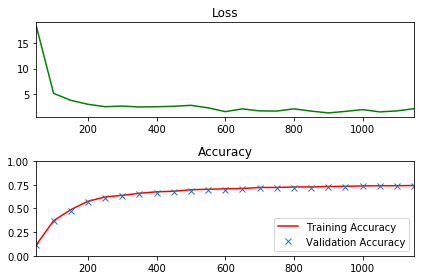

Validation accuracy at 0.7400000095367432


In [90]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

## Test
You're going to test your model against your hold out dataset/testing data.  This will give you a good indicator of how well the model will do in the real world.  You should have a test accuracy of at least 80%.

#### We can run above or we can just add one line to code :
test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
to above as what I did. 

In [93]:
### DON'T MODIFY ANYTHING BELOW ###
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))


Epoch  1/1: 100%|████████████████████████████████████████████████████████████| 1114/1114 [00:02<00:00, 477.58batches/s]

Nice Job! Test Accuracy is 0.8145999908447266


In [92]:
batch_count

1114

# Multiple layers
Good job!  You built a one layer TensorFlow network!  However, you might want to build more than one layer.  This is deep learning after all!  In the next section, you will start to satisfy your need for more layers.